In [ ]:
# %matplotlib inline
# import matplotlib as mpl  # 기본 설정
# import matplotlib.pyplot as plt  # 그래프 그리기
# import matplotlib.font_manager as fm  # 폰트 관리

# !apt-get update -qq         # apt-get 패키지 설치 명령어, -qq : 에러외 메세지 숨기기
# !apt-get install fonts-nanum* -qq #나눔글꼴 설치
# fe = fm.FontEntry(fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', name='NanumGothic') #파일 저장되어있는 경로와 이름 설정
# fm.fontManager.ttflist.insert(0, fe)  # Matplotlib에 폰트 추가
# plt.rcParams.update({'font.size': 10, 'font.family': 'NanumGothic'}) #폰트설정
# mpl.rcParams['axes.unicode_minus'] = False

# 데이터 전처리


In [1]:
# prompt: 마운트

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import datetime
#import nltk
import pandas as pd
import numpy as np
##import gensim
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
#주가데이터 가져오기

#모델 라이브러리
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
#from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
import xgboost as xgb
from sklearn.svm import SVC
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#모델저장 라이브러리
import pickle
import os

In [ ]:
# pd.set_option('display.max_rows', None)
# pd.reset_option('display.max_rows')

In [3]:
import pandas as pd
df=pd.read_excel('/content/drive/MyDrive/KDT/최종 프로젝트/찐찐최종/1조_데이터.xlsx')

In [4]:
df.head()

,Unnamed: 0,index,years,회사명,stock_code,전년도ESG,종합등급,매출액,영업이익,영업이익(발표기준),...,기업분류,상시근로자수,장애인고용의무인원,장애인근로자수,장애인고용률,E_value,S_value,G_value,재무_value,성장성_value
0,0,2019-12-01,2019,동화약품,20,NaN,B,3072.0,96,96,...,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2020-12-01,2020,동화약품,20,B,B,2721.0,232,232,...,5,NaN,NaN,NaN,NaN,-1.512055,1.907624,0.762864,1.808601,0.028586
2,2,2021-12-01,2021,동화약품,20,B,C,2930.0,225,225,...,5,NaN,NaN,NaN,NaN,-1.512055,1.917345,0.884211,1.606126,0.028232
3,3,2022-12-01,2022,동화약품,20,C,C,3404.0,299,299,...,5,NaN,NaN,NaN,NaN,-1.512055,1.914746,0.906279,1.414489,0.028533
4,4,2023-12-01,2023,동화약품,20,C,B이하,3611.0,188,188,...,4,NaN,NaN,NaN,NaN,-1.512055,1.982998,0.888667,1.627199,0.028333


In [5]:
df.head()
df = df.drop(columns=['Unnamed: 0'])
# df = df.drop(columns=['N장애인고용률'])

## 변수 추가 & 파생 변수 생성

In [6]:
wage_increase_percentages_complete = {
    2019: 10.9,
    2020: 2.8,
    2021: 1.5,
    2022: 5.05,
    2023: 5.0
}
# 데이터프레임에 상승률 추가
df['wage_increase_percentage'] = df['years'].map(wage_increase_percentages_complete)

In [7]:
df['장애인고용률'] = df['장애인고용률'].fillna(3.4)
df['장애인근로자수']=df['장애인근로자수'].fillna(df['직원 수']*0.03)
df = df.drop(columns=['기업규모','장애인고용의무인원','상시근로자수'])
df['비지배주주순이익'] = df['비지배주주순이익'].fillna(0)
df['PER'].fillna(0, inplace=True)
df['RE100'].fillna(0, inplace=True)
df['총 평균급여'] = (df['남성 평균 연봉'] * df['남성 정규직 수'] + df['여성 평균 연봉'] * df['여성 정규직 수'])
df['지배주주이익'] = df['당기순이익'] *df['지배주주지분']
df['비지배주주이익'] = df['당기순이익'] *df['비지배주주지분']
df['지배주주지분가치'] = df['지배주주지분'] * df['시가총액']

df['총임원수변화율'] = df.groupby(['회사명'], group_keys=False)['총 임원 수'].apply(lambda x: (x.diff()+1 / (x + 1)) * 100)
df['총임원수변화율'] = df['총임원수변화율'].fillna(1)


# 회사명을 기준으로 그룹화하고 직원변화율 계산
df['총직원수변화율'] = df.groupby(['회사명'],group_keys=False)['직원 수'].apply(lambda x: x.diff()+1 / (x+1) * 100)
df['총직원수변화율'] = df['총직원수변화율'].fillna(1)


df['총 평균급여변화율'] = df.groupby(['회사명'],group_keys=False)['총 평균급여'].apply(lambda x: (x.diff()+1) / (x+1) * 100)
df['총 평균급여변화율'] = df['총 평균급여변화율'].fillna(1)

df['총 PBR변화율'] = df.groupby(['회사명'],group_keys=False)['PBR'].apply(lambda x: (x.diff()+1) / (x+1) * 100)
df['총 PBR변화율'] = df['총 PBR변화율'].fillna(1)

df['총 자본총계변화율'] = df.groupby(['회사명'],group_keys=False)['자본총계'].apply(lambda x: (x.diff()+1) / (x+1) * 100)
df['총 자본총계변화율'] = df['총 자본총계변화율'].fillna(1)

df['총 부채총계변화율'] = df.groupby(['회사명'],group_keys=False)['부채총계'].apply(lambda x: (x.diff()+1) / (x+1) * 100)
df['총 부채총계변화율'] = df['총 부채총계변화율'].fillna(1)

df['총 외국인 보유수량변화율'] = df.groupby(['회사명'],group_keys=False)['외국인 보유수량'].apply(lambda x: (x.diff()+1) / (x+1) * 100)
df['총 외국인 보유수량변화율'] = df['총 외국인 보유수량변화율'].fillna(1)

df['총 외국인 지분율변화율'] = df.groupby(['회사명'],group_keys=False)['외국인 지분율'].apply(lambda x: (x.diff()+1) / (x+1) * 100)
df['총 외국인 지분율변화율'] = df['총 외국인 지분율변화율'].fillna(1)

df['총 시가총액변화율'] = df.groupby(['회사명'],group_keys=False)['시가총액'].apply(lambda x: (x.diff()+1) / (x+1) * 100)
df['총 시가총액변화율'] = df['총 시가총액변화율'].fillna(1)


df['총 여성 임원 수변화율'] = df.groupby(['회사명'],group_keys=False)['여성 임원 수 '].apply(lambda x: (x.diff()+1) / (x+1) * 100)
df['총 여성 임원 수변화율'] = df['총 여성 임원 수변화율'].fillna(1)

df['총 외국인 보유수량변화율'] = df.groupby(['회사명'],group_keys=False)['외국인 보유수량'].apply(lambda x: (x.diff()+1) / (x+1) * 100)
df['총 외국인 보유수량변화율'] = df['총 외국인 보유수량변화율'].fillna(1)

df['주가'] = df['시가총액'] / df['발행주식수']

df['총 주가변화율'] = df.groupby(['회사명'],group_keys=False)['주가'].apply(lambda x: (x.diff()+1) / (x+1) * 100)
df['총 주가변화율'] = df['총 주가변화율'].fillna(1)

df = df.drop(columns=['주가'])

In [8]:
# 2023 , 2019 년도 제거
df = df[(df['years'] != 2019) & (df['years'] != 2023)]

df = df.reset_index(drop=True)

In [9]:
df['정규직비율'] = (df['남성 정규직 수'] + df['여성 정규직 수']) / (df['남성 직원 수'] + df['여성 직원 수'])
df[['정규직비율','여성 직원 수','여성 정규직 수']].describe()

# 시가총액*유보율
df['시가총액_유보율'] = df['시가총액'] * df['유보율']

# 임직원수
df['임직원수'] =  df['직원 수'] + df['총 임원 수']

df['조직의변화율'] = df.groupby(['회사명'], group_keys=False)['임직원수'].apply(lambda x: (x.diff()+1 / (x + 1)) * 100)
df['조직의변화율'] = df['조직의변화율'].fillna(1)

# 시가총액 * 배당수익률
df['시가총액_배당수익률'] = df['시가총액'] * df['배당수익률']

# 환경지표
df['환경지표'] = (df['에너지 총량 등급'] * df['온실가스 배출총량 등급'] * df['용수 사용량 등급']) / 3

# 효율성지표
df['효율성지표'] = df['매출액'] / df['자산총계']

# 임직원수 drop
df = df.drop(columns=['임직원수'])

In [10]:
#df에 연도컬럼 제거
df = df.drop(columns=['years','stock_code','용수 사용량(Ton)','에너지 총량(TJ)','온실가스 배출총량(TonCo2eq)', 'PER','회사명'])
df=df.dropna()
df.reset_index(drop=True, inplace=True)

In [11]:
### 전년도 ESG 범주화
# 4단계로 나눔
def pre_convert_grade(grade):
    if grade in ['A+']:
        return 3
    if grade in ['A']:
        return 2
    if grade in ['B+']:
        return 1
    if grade in ['B']:
        return 0
    if grade in ['C','.C']:
        return 0
    if grade in ['D']:
        return 0


# apply 메서드와 lambda 함수를 사용하여 종합등급컬럼 생성
df['전년도ESG'] = df['전년도ESG'].apply(lambda x: pre_convert_grade(x))

In [12]:
# 컬럼 정렬

signal_column = df.pop('GICS_Industry')
df.insert(0, 'GICS_Industry', signal_column)
signal_column = df.pop('녹색 기업 지정')
df.insert(0, '녹색 기업 지정', signal_column)
signal_column = df.pop('GICS_Sector')
df.insert(0, 'GICS_Sector', signal_column)
# signal_column = df.pop('비지배주주순이익')
# df.insert(35, '비지배주주순이익', signal_column)
signal_column = df.pop('자산총계')
df.insert(0, '자산총계', signal_column)
signal_column = df.pop('종합등급')
df.insert(0, '종합등급', signal_column)
signal_column = df.pop('index')
df.insert(0, 'index', signal_column)
df.head()

,index,종합등급,자산총계,GICS_Sector,녹색 기업 지정,GICS_Industry,전년도ESG,매출액,영업이익,영업이익(발표기준),...,총 외국인 지분율변화율,총 시가총액변화율,총 여성 임원 수변화율,총 주가변화율,정규직비율,시가총액_유보율,조직의변화율,시가총액_배당수익률,환경지표,효율성지표
0,2020-12-01,B,4338,Healthcare,0,Drug Manufacturers - Specialty & Generic,0,2721.0,232,232,...,1.000000,57.709924,50.0,57.709926,0.979702,6.009890e+14,1.000000,5.049451e+11,41.666667,0.627248
1,2021-12-01,C,4478,Healthcare,0,Drug Manufacturers - Specialty & Generic,0,2930.0,225,225,...,7.440476,-34.589041,25.0,-34.589032,0.979508,4.686146e+14,-499.867550,5.015933e+11,41.666667,0.654310
2,2022-12-01,C,4611,Healthcare,0,Drug Manufacturers - Specialty & Generic,0,3404.0,299,299,...,54.615385,-57.667387,40.0,-57.667370,0.975515,3.133903e+14,4300.125313,5.017721e+11,41.666667,0.738235
3,2020-12-01,C,1559,Consumer Cyclical,0,Recreational Vehicles,0,1178.0,12,12,...,1.000000,49.195206,100.0,13.974146,1.000000,-3.642274e+12,1.000000,0.000000e+00,41.666667,0.755613
4,2021-12-01,D,1684,Consumer Cyclical,0,Recreational Vehicles,0,1335.0,-27,-27,...,2.288620,-25.104290,100.0,-31.215254,1.000000,-3.597451e+12,-1198.305085,0.000000e+00,41.666667,0.792755


## 타겟 인코딩

In [13]:
df_target_enc = df.copy()

In [14]:
# 4단계로 나눔
def convert_grade(grade):
    if grade in ['A+']:
        return 3
    if grade in ['A']:
        return 2
    if grade in ['B+']:
        return 1
    if grade in ['B']:
        return 0
    if grade in ['C','.C']:
        return 0
    if grade in ['D']:
        return 0

# apply 메서드와 lambda 함수를 사용하여 종합등급컬럼 생성
df_target_enc['종합등급'] = df_target_enc['종합등급'].apply(lambda x: convert_grade(x))

In [ ]:
# # 2단계로 나눔
# def convert_grade(grade):
#     if grade in ['A+']:
#         return 1
#     if grade in ['A']:
#         return 1
#     if grade in ['B+']:
#         return 1
#     if grade in ['B']:
#         return 0
#     if grade in ['C','.C']:
#         return 0
#     if grade in ['D']:
#         return 0

# # apply 메서드와 lambda 함수를 사용하여 종합등급컬럼 생성
# df_target_enc['종합등급'] = df_target_enc['종합등급'].apply(lambda x: convert_grade(x))

In [15]:
df

,index,종합등급,자산총계,GICS_Sector,녹색 기업 지정,GICS_Industry,전년도ESG,매출액,영업이익,영업이익(발표기준),...,총 외국인 지분율변화율,총 시가총액변화율,총 여성 임원 수변화율,총 주가변화율,정규직비율,시가총액_유보율,조직의변화율,시가총액_배당수익률,환경지표,효율성지표
0,2020-12-01,B,4338,Healthcare,0,Drug Manufacturers - Specialty & Generic,0,2721.0,232,232,...,1.000000,57.709924,50.0,57.709926,0.979702,6.009890e+14,1.000000,5.049451e+11,41.666667,0.627248
1,2021-12-01,C,4478,Healthcare,0,Drug Manufacturers - Specialty & Generic,0,2930.0,225,225,...,7.440476,-34.589041,25.0,-34.589032,0.979508,4.686146e+14,-499.867550,5.015933e+11,41.666667,0.654310
2,2022-12-01,C,4611,Healthcare,0,Drug Manufacturers - Specialty & Generic,0,3404.0,299,299,...,54.615385,-57.667387,40.0,-57.667370,0.975515,3.133903e+14,4300.125313,5.017721e+11,41.666667,0.738235
3,2020-12-01,C,1559,Consumer Cyclical,0,Recreational Vehicles,0,1178.0,12,12,...,1.000000,49.195206,100.0,13.974146,1.000000,-3.642274e+12,1.000000,0.000000e+00,41.666667,0.755613
4,2021-12-01,D,1684,Consumer Cyclical,0,Recreational Vehicles,0,1335.0,-27,-27,...,2.288620,-25.104290,100.0,-31.215254,1.000000,-3.597451e+12,-1198.305085,0.000000e+00,41.666667,0.792755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1969,2022-12-01,C,3050,Consumer Cyclical,0,Restaurants,0,5175.0,88,88,...,78.740157,-80.434783,50.0,-80.434763,0.923077,3.037189e+14,4100.265957,4.987514e+11,41.666667,1.696721
1970,2022-12-01,C,48704,Communication Services,0,Entertainment,0,17762.0,2369,2369,...,-7.376523,-101.152738,100.0,-101.152737,0.956311,9.541812e+16,-3799.842767,0.000000e+00,0.333333,0.364693
1971,2022-12-01,A,11918,Technology,0,Electronic Components,1,13162.0,2325,2325,...,31.573803,-31.746032,100.0,-31.746025,0.805673,3.006986e+15,4800.037850,1.980037e+12,1.000000,1.104380
1972,2022-12-01,B+,22830,Communication Services,0,Broadcasting,1,3326.0,168,168,...,6.416275,-112.855402,100.0,-112.855381,1.000000,3.240483e+15,803.225806,7.663836e+11,0.333333,0.145686


In [16]:
df_target_enc['전년도ESG'].unique()

array([0, 1, 2, 3])

In [17]:
# 종합등급을 기준으로 GICS_Sector 열을 타겟 인코딩
target_mean_sector = df_target_enc.groupby('GICS_Sector')['종합등급'].mean().to_dict()
df_target_enc['GICS_Sector_encoded'] = df_target_enc['GICS_Sector'].map(target_mean_sector)

# 종합등급을 기준으로 GICS_Industry 열을 타겟 인코딩
target_mean_industry = df_target_enc.groupby('GICS_Industry')['종합등급'].mean().to_dict()
df_target_enc['GICS_Industry_encoded'] = df_target_enc['GICS_Industry'].map(target_mean_industry)

# 종합등급을 기준으로 전년도 ESG 열 타겟 인코딩
target_mean_ESG = df_target_enc.groupby('전년도ESG')['종합등급'].mean().to_dict()
df_target_enc['target_ESG'] = df_target_enc['전년도ESG'].map(target_mean_ESG)

# # 종합등급을 기준으로 업종명 열 타겟 인코딩
# target_mean_업종명 = df_target_enc.groupby('업종명')['종합등급'].mean().to_dict()
# df_target_enc['업종명_encoded'] = df_target_enc['업종명'].map(target_mean_업종명)

# GICS_Sector, GICS_Industry 전년도ESG 열 제거
df = df_target_enc.drop(columns=['GICS_Sector', 'GICS_Industry', '전년도ESG'])

In [18]:
columns_to_move = [
    '이사의 수', '사외이사 수', '사외이사 비율', '총 임원 수', '여성 임원 수 ', '여성 임원 비율',
    '남성 평균 연봉', '여성 평균 연봉', '남성 정규직 수', '여성 정규직 수', '남성 직원 수', '여성 직원 수', '직원 수',
    '여성 직원 비율', '남성 직원 비율', '남성 정규직 비율', '여성 정규직 비율'
]

# 나머지 컬럼 리스트
remaining_columns = [col for col in df.columns if col not in columns_to_move]

# 새로운 컬럼 순서로 데이터프레임 재정렬
new_column_order = remaining_columns + columns_to_move
df = df[new_column_order]

In [19]:
df['종합등급'].value_counts()

종합등급
0    1252
2     367
1     330
3      25
Name: count, dtype: int64

### K_Means

In [20]:
# 각 변수에 대해 최적의 클러스터 개수 결정
"""
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt  # matplotlib.pyplot import 추가

np.random.seed(0)
columns = ['매출액', '남성 직원 비율', '여성 직원 비율', '사외이사 비율', '여성 임원 비율', '남성 평균 연봉', '여성 평균 연봉', '남성 정규직 비율', '여성 정규직 비율']

for col in columns:
    inertia = []
    for k in range(1, 11):  # 시도할 클러스터 개수 범위 설정 (1에서 10까지)
        kmeans = KMeans(n_clusters=k, random_state=0)
        X = df[[col]]
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)

    # 엘보우 메서드 그래프 그리기
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title(f'Elbow Method for {col}')  # 컬럼명을 제목에 추가
    plt.xticks(range(1, 11))
    plt.grid(True)
    plt.show()
"""

"\nfrom sklearn.cluster import KMeans\nimport numpy as np\nimport matplotlib.pyplot as plt  # matplotlib.pyplot import 추가\n\nnp.random.seed(0)\ncolumns = ['매출액', '남성 직원 비율', '여성 직원 비율', '사외이사 비율', '여성 임원 비율', '남성 평균 연봉', '여성 평균 연봉', '남성 정규직 비율', '여성 정규직 비율']\n\nfor col in columns:\n    inertia = []\n    for k in range(1, 11):  # 시도할 클러스터 개수 범위 설정 (1에서 10까지)\n        kmeans = KMeans(n_clusters=k, random_state=0)\n        X = df[[col]]\n        kmeans.fit(X)\n        inertia.append(kmeans.inertia_)\n\n    # 엘보우 메서드 그래프 그리기\n    plt.figure(figsize=(8, 6))\n    plt.plot(range(1, 11), inertia, marker='o', linestyle='--')\n    plt.xlabel('Number of clusters')\n    plt.ylabel('Inertia')\n    plt.title(f'Elbow Method for {col}')  # 컬럼명을 제목에 추가\n    plt.xticks(range(1, 11))\n    plt.grid(True)\n    plt.show()\n"

In [21]:
# 각 컬럼별 군집 개수
n_clusters_list = [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]

In [22]:
# 각 변수에 대해 다른 클러스터 개수 지정
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt  # matplotlib.pyplot import 추가
columns = ['매출액', '남성 직원 비율', '여성 직원 비율', '사외이사 비율', '여성 임원 비율', '남성 평균 연봉', '여성 평균 연봉', '남성 정규직 비율', '여성 정규직 비율']
columns = ['매출액', '남성 직원 비율', '여성 직원 비율', '사외이사 비율', '여성 임원 비율', '남성 평균 연봉', '여성 평균 연봉', '남성 정규직 비율', '여성 정규직 비율','장애인고용률','장애인근로자수']



# 각 변수에 대해 K-means 클러스터링 모델 초기화 및 훈련
for col, n_clusters in zip(columns, n_clusters_list):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    X = df[[col]]
    kmeans.fit(X)
    df[f'{col}_cluster'] = kmeans.labels_
df=df.drop(columns=['장애인고용률','장애인근로자수'])

### MinMaxScaler

In [23]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# 수치형 컬럼 선택

numeric_cols = ['자산총계','매출액','영업이익', '영업이익(발표기준)','당기순이익','지배주주순이익','부채총계','자본총계','지배주주지분','비지배주주지분','자본금','부채비율','유보율','영업이익률','지배주주순이익률','ROA','ROE','EPS(원)','BPS(원)','DPS(원)','PBR','발행주식수','배당수익률',
                '매출액_상승률(퍼센트)', '영업이익_상승률', '배당수익률_상승률', '영업이익률_상승률', '외국인 보유수량','상장주식수',
                '총 평균급여', 'GICS_Sector_encoded', 'GICS_Industry_encoded', 'target_ESG',
                '이사의 수', '사외이사 수', '사외이사 비율', '총 임원 수', '여성 임원 수 ', '여성 임원 비율', '남성 평균 연봉', '여성 평균 연봉', '남성 정규직 수', '여성 정규직 수', '남성 직원 수', '여성 직원 수', '직원 수', '여성 직원 비율', '남성 직원 비율', '남성 정규직 비율', '여성 정규직 비율','지배주주이익','시가총액',
                '외국인 지분율','wage_increase_percentage']

non_numeric_cols = df.columns.difference(numeric_cols)
# 스케일링 적용
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# 데이터 예측 분석

In [24]:
df1 = df.copy()
df1.head()

,index,종합등급,자산총계,녹색 기업 지정,매출액,영업이익,영업이익(발표기준),당기순이익,지배주주순이익,비지배주주순이익,...,남성 직원 비율_cluster,여성 직원 비율_cluster,사외이사 비율_cluster,여성 임원 비율_cluster,남성 평균 연봉_cluster,여성 평균 연봉_cluster,남성 정규직 비율_cluster,여성 정규직 비율_cluster,장애인고용률_cluster,장애인근로자수_cluster
0,2020-12-01,0,0.000921,0,0.000893,0.102117,0.102117,0.086156,0.088832,2.0,...,2,2,0,2,0,2,0,0,0,0
1,2021-12-01,0,0.000952,0,0.000962,0.102104,0.102104,0.086007,0.088656,17.0,...,2,2,1,2,0,2,0,0,0,0
2,2022-12-01,0,0.000982,0,0.001119,0.102233,0.102233,0.086040,0.088697,12.0,...,2,2,1,2,0,2,0,0,0,0
3,2020-12-01,0,0.000302,0,0.000382,0.101734,0.101734,0.085496,0.088223,-34.0,...,0,1,1,0,0,2,0,0,0,0
4,2021-12-01,0,0.000329,0,0.000434,0.101666,0.101666,0.085489,0.088199,-25.0,...,0,1,0,0,0,2,0,0,0,0


In [ ]:
# # 히스토그램 시각화

# plt.figure(figsize=(10, 6))
# plt.hist(df1['종합등급'], bins=[-0.5, 0.5, 1.5, 2.5, 3.5], edgecolor='black', alpha=0.7)
# plt.xticks([0, 1, 2, 3])  # x축 눈금 설정
# plt.title('종합등급')
# plt.xlabel('종합등급')
# plt.ylabel('빈도수')
# plt.grid(axis='y', alpha=0.75)
# plt.show()

#### SMOTE

In [25]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import KMeansSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.cluster import MiniBatchKMeans

X = df1.drop(columns=['index','종합등급'])
y = df1['종합등급']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.193, random_state=0)

# # SMOTE 적용
# smote = SMOTE(random_state=0)
smote = KMeansSMOTE(kmeans_estimator=MiniBatchKMeans(n_init=3, random_state=0),cluster_balance_threshold=0.21, random_state = 38)
X_train, y_train = smote.fit_resample(X_train,y_train)

# 결과 확인
print("클래스 별 개수 (트레이닝 데이터):")
print(y_train.value_counts())

클래스 별 개수 (트레이닝 데이터):
종합등급
2    1001
1     999
0     996
3     996
Name: count, dtype: int64


In [ ]:
# # 데이터프레임 생성
# df_y = pd.DataFrame(y_train, columns=['종합등급'])

# # 히스토그램 그리기
# plt.figure(figsize=(8, 6))
# plt.hist(df_y['종합등급'], bins=[-0.5, 0.5, 1.5, 2.5, 3.5], edgecolor='black', alpha=0.7)
# plt.title('종합등급')
# plt.xlabel('종합등급')
# plt.ylabel('빈도수')
# plt.xticks([0, 1, 2, 3])
# plt.grid(axis='y')
# plt.show()

In [26]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.0 MB/s eta 0:00:00


In [ ]:
# y_test.unique()

#### 모델 생성 및 평가

In [27]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
# 클래스 가중치 계산
from sklearn.utils import class_weight
class_weights = compute_class_weight(class_weight = 'balanced',
                               classes = np.unique(y_train),
                               y = y_train)
models = {
    # "MLP Classifier": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, alpha=1e-4,
    #                                 solver='adam', verbose=0, tol=1e-4, random_state=41,
    #                                 learning_rate_init=.1),
    "Random Forest Classifier": RandomForestClassifier(class_weight=dict(enumerate(class_weights)), random_state=0),
#    "linear_model.LinearRegression()":linear_model.LinearRegression(),
    # "KNN": KNeighborsClassifier(),
#    "Support Vector Classifier": SVC(class_weight=dict(enumerate(class_weights)), random_state=41),
    # 다른 모델들도 필요에 따라 class_weight 파라미터를 추가해줍니다.
    "Gradient Boosting": GradientBoostingClassifier(random_state=0, n_estimators = 120),
    # "Decision Tree Classifier": DecisionTreeClassifier(class_weight=dict(enumerate(class_weights)), random_state=41),
    # "Bagging": BaggingClassifier(random_state=41),
    # "Extra Trees Classifier": ExtraTreesClassifier(class_weight=dict(enumerate(class_weights)), random_state=0),
    "Hist Gradient Boosting": HistGradientBoostingClassifier(random_state=0),
    "XGB Classifier": xgb.XGBClassifier(seed=0),
    'LGBM': LGBMClassifier(random_state=0),
    'CatBoost': CatBoostClassifier(random_state=41, verbose=0),

}
lst_feature_importances = []

lst_pred = []
# 각 모델의 정확도를 출력합니다.
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    if hasattr(model, 'feature_importances_'):
        lst_feature_importances.append(model.feature_importances_)
    else:
        lst_feature_importances.append(name)  # 예외 처리: 해당 모델에 feature_importances_ 속성이 없으면 None 추가

    accuracy = accuracy_score(y_test,y_pred)
    lst_pred.append(y_pred)
    f1_scores = f1_score(y_test,y_pred, average='macro')
    recall_scores = recall_score(y_test,y_pred, average='macro')

    # 커스텀 정확도 계산
    print("{} Mean Cross-Validation Accuracy Score: {} f1score:{} recall{}".format(name, accuracy, f1_scores, recall_scores))

Random Forest Classifier Mean Cross-Validation Accuracy Score: 0.8241469816272966 f1score:0.5139521399957832 recall0.5109078617860188
Gradient Boosting Mean Cross-Validation Accuracy Score: 0.8267716535433071 f1score:0.6697411697411698 recall0.6654376798273658
Hist Gradient Boosting Mean Cross-Validation Accuracy Score: 0.8267716535433071 f1score:0.5782691040843214 recall0.5582612358802217
XGB Classifier Mean Cross-Validation Accuracy Score: 0.863517060367454 f1score:0.7481261194552942 recall0.7068545862638534
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21771
[LightGBM] [Info] Number of data points in the train set: 3992, number of used features: 112
[LightGBM] [Info] Start training from score -1.388300
[LightGBM] [Info] Start training from score -1.385293
[Light

In [ ]:
# 클래스별 F1-score 계산
f1_scores = f1_score(y_test, lst_pred[4], average=None)

# 각 클래스별 F1-score 출력
for i, score in enumerate(f1_scores):
    print(f"Class {i}: F1-score = {score}")

Class 0: F1-score = 0.9333333333333332
Class 1: F1-score = 0.36363636363636365
Class 2: F1-score = 0.6713286713286714
Class 3: F1-score = 0.0


### Accuracy 막대그래프

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21771
[LightGBM] [Info] Number of data points in the train set: 3992, number of used features: 112
[LightGBM] [Info] Start training from score -1.388300
[LightGBM] [Info] Start training from score -1.385293
[LightGBM] [Info] Start training from score -1.383293
[LightGBM] [Info] Start training from score -1.388300
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44033 (\N{HANGUL SYLLABLE GAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/

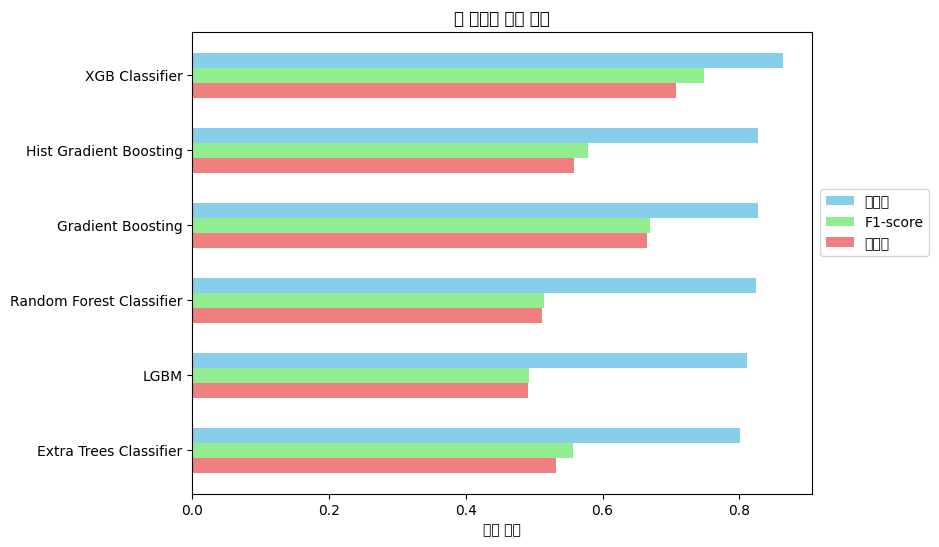

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.utils.class_weight import compute_class_weight

# X_train, X_test, y_train, y_test이 이미 정의되어 있다고 가정합니다.

# 클래스 가중치 계산
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

# 모델 정의
models = {
    "Random Forest Classifier": RandomForestClassifier(class_weight=dict(enumerate(class_weights)), random_state=0),
    "Gradient Boosting": GradientBoostingClassifier(random_state=0, n_estimators=120),
    "Extra Trees Classifier": ExtraTreesClassifier(class_weight=dict(enumerate(class_weights)), random_state=0),
    "Hist Gradient Boosting": HistGradientBoostingClassifier(random_state=0),
    'LGBM': LGBMClassifier(random_state=0),
    "XGB Classifier": xgb.XGBClassifier(seed=0),
}

# 결과를 저장할 리스트
results = []
model_names = []

# 각 모델에 대해 반복
for name, model in models.items():
    # 모델 학습 및 예측
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # 정확도, F1-score, 재현율 계산
    accuracy = accuracy_score(y_test, y_pred)
    f1_scores = f1_score(y_test, y_pred, average='macro')
    recall_scores = recall_score(y_test, y_pred, average='macro')

    # 결과 저장
    results.append([accuracy, f1_scores, recall_scores])
    model_names.append(name)

# 결과를 numpy 배열로 변환
results = np.array(results)
model_names = np.array(model_names)

# 정확도, F1-score, 재현율 각각에서 가장 높은 값 찾기
# max_accuracy_idx = np.argmax(results[:, 0])
# max_f1_idx = np.argmax(results[:, 1])
# max_recall_idx = np.argmax(results[:, 2])

# 정확도를 기준으로 모델들을 내림차순으로 정렬한 인덱스
sorted_indices = np.argsort(results[:, 0])[::-1]

# 시각화를 위한 그래프 생성
fig, ax = plt.subplots(figsize=(8, 6))

# 막대 그래프의 위치 설정
bar_width = 0.2
bar_positions = np.arange(len(models))

# 각 모델의 정확도, F1-score, 재현율을 하나의 막대로 그리기
rects1 = ax.barh(bar_positions - bar_width, results[sorted_indices, 0], bar_width, align='center', label='정확도', color='skyblue')
rects2 = ax.barh(bar_positions, results[sorted_indices, 1], bar_width, align='center', label='F1-score', color='lightgreen')
rects3 = ax.barh(bar_positions + bar_width, results[sorted_indices, 2], bar_width, align='center', label='재현율', color='lightcoral')

# 축 레이블과 제목 설정
ax.set_yticks(bar_positions)
ax.set_yticklabels(model_names[sorted_indices])
ax.invert_yaxis()  # 모델 이름을 정확도가 높은 순서대로 표시하기 위해 y축 반전
ax.set_xlabel('성능 지표')
ax.set_title('각 모델의 성능 비교')

# 범례 추가
plt.legend(loc='lower right', bbox_to_anchor=(1.2, 0.5))

# 그래프 표시
plt.show()

#### XGB Random_state

In [ ]:
# from sklearn.model_selection import train_test_split
# from imblearn.over_sampling import KMeansSMOTE
# from xgboost import XGBClassifier
# from sklearn.metrics import accuracy_score

# # 데이터 준비
# X = df1.drop(columns=['index', '종합등급'])
# y = df1['종합등급']

# # 최적의 random_state와 그 때의 정확도 저장할 변수 초기화
# best_accuracy = 0
# best_random_state = 0

# # 0부터 100까지의 random_state 값을 반복적으로 시도
# for random_state in range(43):
#     try:
#         # 데이터 분할
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.193, random_state=random_state)

#         # KMeansSMOTE를 사용하여 샘플링
#         smote = KMeansSMOTE(kmeans_estimator=MiniBatchKMeans(n_init=3, random_state=0),cluster_balance_threshold=0.21, random_state = 38)
#         X_train_resampled, y_train_resampled = smote.fit_resample(X_train,y_train)

#         # XGBoost 모델 초기화 및 학습
#         xgb_model = XGBClassifier(seed=0)
#         xgb_model.fit(X_train_resampled, y_train_resampled)

#         # 테스트 데이터로 예측
#         y_pred_xgb = xgb_model.predict(X_test)

#         # 정확도 계산
#         accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

#         # 현재 random_state에 대한 정확도 출력
#         print("Random State {}: Accuracy = {:.2f}%".format(random_state, accuracy_xgb * 100))

#         # 가장 높은 정확도와 그 때의 random_state 저장
#         if accuracy_xgb > best_accuracy:
#             best_accuracy = accuracy_xgb
#             best_random_state = random_state
#     except RuntimeError as e:
#         # 예외 처리: RuntimeError 발생 시 해당 random_state 건너뛰기
#         print(f"Random State {random_state}: RuntimeError - {e}. Skipping...")
#         continue

# # 최적의 random_state와 그 때의 정확도 출력
# print("\n최적의 Random State: {}, 최고 정확도: {:.2f}%".format(best_random_state, best_accuracy * 100))

Random State 0: Accuracy = 86.35%
Random State 1: Accuracy = 78.74%
Random State 2: Accuracy = 78.74%
Random State 3: Accuracy = 78.74%
Random State 4: Accuracy = 78.22%
Random State 5: RuntimeError - No clusters found with sufficient samples of class 3. Try lowering the cluster_balance_threshold or increasing the number of clusters.. Skipping...
Random State 6: Accuracy = 83.99%
Random State 7: Accuracy = 76.38%
Random State 8: Accuracy = 77.43%
Random State 9: Accuracy = 78.22%
Random State 10: Accuracy = 77.43%
Random State 11: RuntimeError - No clusters found with sufficient samples of class 3. Try lowering the cluster_balance_threshold or increasing the number of clusters.. Skipping...
Random State 12: Accuracy = 76.64%
Random State 13: Accuracy = 79.27%
Random State 14: Accuracy = 80.58%
Random State 15: Accuracy = 72.97%
Random State 16: Accuracy = 76.64%
Random State 17: RuntimeError - No clusters found with sufficient samples of class 3. Try lowering the cluster_balance_thresh

In [ ]:
# from xgboost import XGBClassifier
# from sklearn.metrics import accuracy_score, f1_score, recall_score
# from sklearn.model_selection import train_test_split
# from imblearn.over_sampling import KMeansSMOTE
# from sklearn.cluster import MiniBatchKMeans
# import numpy as np
# from itertools import product

# # 데이터 준비 (df1은 이미 준비된 데이터프레임이라고 가정)
# X = df1.drop(columns=['index', '종합등급'])
# y = df1['종합등급']

# # 데이터 분할
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# # 반복할 random_state 값 리스트
# random_state_list = list(range(0,101))  # 원하는 다른 값을 추가할 수 있습니다.
# # n_init_list = list(range(3,4))

# # 각 random_state에 대한 성능 지표를 저장할 리스트
# accuracy_scores = []
# f1_scores = []
# recall_scores = []

# for n_init, random_state_val in product(n_init_list, random_state_list):
#     try:
#         # KMeansSMOTE 적용
#         smote = KMeansSMOTE(kmeans_estimator=MiniBatchKMeans(n_init= 3, random_state=random_state_val), cluster_balance_threshold=0.21, random_state=38)
#         X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

#         # XGBClassifier 모델 정의
#         xgb_model = XGBClassifier(seed=0)

#         # 모델 훈련
#         xgb_model.fit(X_train_resampled, y_train_resampled)

#         # 테스트 데이터 예측
#         y_pred_xgb = xgb_model.predict(X_test)

#         # 정확도, F1 점수, 재현율 계산
#         accuracy = accuracy_score(y_test, y_pred_xgb)
#         f1 = f1_score(y_test, y_pred_xgb, average='macro')
#         recall = recall_score(y_test, y_pred_xgb, average='macro')

#         # 결과 저장
#         accuracy_scores.append(accuracy)
#         f1_scores.append(f1)
#         recall_scores.append(recall)

#         # 결과 출력
#         print(f"n_init: {n_init}, random_state: {random_state_val}")
#         print("정확도:", accuracy)
#         print("F1 점수:", f1)
#         print("재현율:", recall)
#         print("-" * 50)

#     except RuntimeError as e:
#         print(f"n_init: {n_init}, random_state: {random_state_val} - Error: {str(e)}")
#         print("Skipping this iteration due to an error.")
#         print("-" * 50)
#         continue

# # 최적의 random_state 선택
# best_index = np.argmax(accuracy_scores)  # 정확도가 가장 높은 인덱스 선택
# best_random_state = random_state_list[best_index]
# print(f"최적의 random_state 값: {best_random_state}")

n_init: 3, random_state: 0 - Error: No clusters found with sufficient samples of class 3. Try lowering the cluster_balance_threshold or increasing the number of clusters.
Skipping this iteration due to an error.
--------------------------------------------------
n_init: 3, random_state: 1
정확도: 0.8278481012658228
F1 점수: 0.6058466940581398
재현율: 0.5744900872537729
--------------------------------------------------
n_init: 3, random_state: 2
정확도: 0.8329113924050633
F1 점수: 0.6683365080296862
재현율: 0.6254406575959782
--------------------------------------------------
n_init: 3, random_state: 3 - Error: No clusters found with sufficient samples of class 3. Try lowering the cluster_balance_threshold or increasing the number of clusters.
Skipping this iteration due to an error.
--------------------------------------------------
n_init: 3, random_state: 4
정확도: 0.8329113924050633
F1 점수: 0.606623702112424
재현율: 0.5714430535541011
--------------------------------------------------
n_init: 3, random_s

#### 수정된 Accuracy

In [ ]:
# y_pred_xgb = xgb_model.predict_proba(X_test)
# def top_two_predictions(proba):
#     top_1 = np.argmax(proba, axis=1)
#     top_2 = np.argsort(proba, axis=1)[:, -2]
#     return top_1, top_2

# top_1, top_2 = top_two_predictions(y_pred_xgb)

In [ ]:
# len(y_pred_xgb)

In [ ]:
# def custom_accuracy_score(y_true, top_1, top_2):
#     correct_predictions = (top_1 == y_true) | (top_2 == y_true)
#     accuracy = np.mean(correct_predictions)
#     return accuracy

# custom_accuracy = custom_accuracy_score(y_test, top_1, top_2)
# print("Custom Accuracy:", custom_accuracy)

In [ ]:
# # 예측 확률 배열
# y_pred_proba = xgb_model.predict_proba(X_test)

# # top_1과 top_2의 확률 가져오기
# top_1_prob = y_pred_proba[np.arange(len(top_1)), top_1]
# top_2_prob = y_pred_proba[np.arange(len(top_2)), top_2]

# # 각 샘플에 대한 top_1과 top_2의 확률 출력
# # for i in range(len(top_1)):
# #     print(f"Sample {i + 1}:")
# #     print(f"Top 1 Class: {top_1[i]} (Probability: {top_1_prob[i]})")
# #     print(f"Top 2 Class: {top_2[i]} (Probability: {top_2_prob[i]})")
# #     print()

# # top_1_prob, top_2, top_2_prob 데이터 프레임으로 만들기
# df_prob = pd.DataFrame({'Top 1 Probability': top_1_prob, 'Top 2': top_2, 'Top 2 Probability': top_2_prob})
# df_prob

# 기타

## GridSearchCV

In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import accuracy_score, f1_score, recall_score
# import xgboost as xgb

# # XGBClassifier 하이퍼파라미터 그리드 정의
# param_grid = {
#     'max_depth': [3, 5, 7],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0]
# }

# # XGBoost 모델 정의
# xgb_model = xgb.XGBClassifier(random_state=0)

# # GridSearchCV를 사용하여 하이퍼파라미터 튜닝 (scoring을 accuracy로 변경)
# grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
#                            scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

# # 모델 학습
# grid_search.fit(X_train, y_train)

# # 최적의 하이퍼파라미터 출력
# print("최적 하이퍼파라미터:", grid_search.best_params_)
# print("최고 정확도 점수:", grid_search.best_score_)

# # 최적의 모델로 테스트 데이터 예측
# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_test)

# # 정확도 및 F1 점수 계산
# accuracy = accuracy_score(y_test, y_pred)
# f1_scores = f1_score(y_test, y_pred, average='macro')
# recall_scores = recall_score(y_test, y_pred, average='macro')

# print("테스트 정확도: ", accuracy)
# print("테스트 F1 점수: ", f1_scores)
# print("테스트 Recall 점수: ", recall_scores)

## RandomizedSearchCV

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV
# import xgboost as xgb

# # XGBClassifier 하이퍼파라미터 랜덤 검색 정의
# param_dist = {
#     'max_depth': [3, 5, 7, 9],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'n_estimators': [50, 100, 150],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0],
#     'gamma': [0, 0.1, 0.2]
# }

# # XGBoost 모델 정의
# xgb_model = xgb.XGBClassifier(random_state=0)

# # RandomizedSearchCV를 사용하여 하이퍼파라미터 튜닝
# random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist,
#                                    n_iter=50, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

# # 모델 학습
# random_search.fit(X_train, y_train)

# # 최적의 하이퍼파라미터 출력
# print("최적 하이퍼파라미터:", random_search.best_params_)
# print("최고 정확도 점수:", random_search.best_score_)

# # 최적의 모델로 테스트 데이터 예측
# best_model = random_search.best_estimator_
# y_pred = best_model.predict(X_test)

# # 정확도 및 F1 점수 계산
# accuracy = accuracy_score(y_test, y_pred)
# f1_scores = f1_score(y_test, y_pred, average='macro')
# recall_scores = recall_score(y_test, y_pred, average='macro')

# print("테스트 정확도: ", accuracy)
# print("테스트 F1 점수: ", f1_scores)
# print("테스트 Recall 점수: ", recall_scores)

## Bayesian Optimization

In [ ]:
# !pip install scikit-optimize

In [ ]:
# from skopt import BayesSearchCV
# import xgboost as xgb

# # XGBClassifier 하이퍼파라미터 베이지안 최적화 정의
# param_dist = {
#     'max_depth': (3, 9),
#     'learning_rate': (0.01, 0.3, 'uniform'),
#     'n_estimators': (50, 200),
#     'subsample': (0.5, 1.0, 'uniform'),
#     'colsample_bytree': (0.5, 1.0, 'uniform'),
#     'gamma': (0, 0.2, 'uniform')
# }

# # XGBoost 모델 정의
# xgb_model = xgb.XGBClassifier(random_state=0)

# # Bayesian Optimization을 사용하여 하이퍼파라미터 튜닝
# opt = BayesSearchCV(
#     xgb_model,
#     param_dist,
#     n_iter=50,
#     scoring='accuracy',
#     cv=5,
#     verbose=1,
#     n_jobs=-1
# )

# # 모델 학습
# opt.fit(X_train, y_train)

# # 최적의 하이퍼파라미터 출력
# print("최적 하이퍼파라미터:", opt.best_params_)
# print("최고 정확도 점수:", opt.best_score_)

# # 최적의 모델로 테스트 데이터 예측
# best_model = opt.best_estimator_
# y_pred = best_model.predict(X_test)

# # 정확도 및 F1 점수 계산
# accuracy = accuracy_score(y_test, y_pred)
# f1_scores = f1_score(y_test, y_pred, average='macro')
# recall_scores = recall_score(y_test, y_pred, average='macro')

# print("테스트 정확도: ", accuracy)
# print("테스트 F1 점수: ", f1_scores)
# print("테스트 Recall 점수: ", recall_scores)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score

# Define the parameter grid for GradientBoostingClassifier
param_grid_gbm = {
    'n_estimators': [120]
}

# Create the GradientBoostingClassifier model
gbm_model = GradientBoostingClassifier(random_state=41)

# Set up GridSearchCV
grid_search_gbm = GridSearchCV(estimator=gbm_model,
                                param_grid=param_grid_gbm,
                                scoring='f1_macro',  # Use F1 score for scoring
                                cv=5,  # 5-fold cross-validation
                                n_jobs=-1,
                                verbose=2)

# Fit GridSearchCV
grid_search_gbm.fit(X_train, y_train)

# Output the best parameters and score
print("Best Parameters for Gradient Boosting: ", grid_search_gbm.best_params_)
print("Best F1 Score for Gradient Boosting: ", grid_search_gbm.best_score_)

# Use the best estimator to predict
best_gbm_model = grid_search_gbm.best_estimator_
y_pred_gbm = best_gbm_model.predict(X_test)

# Evaluate the model
accuracy_gbm = accuracy_score(y_test, y_pred_gbm)
f1_score_gbm = f1_score(y_test, y_pred_gbm, average='macro')
recall_score_gbm = recall_score(y_test, y_pred_gbm, average='macro')

print("Gradient Boosting Classifier Accuracy: ", accuracy_gbm)
print("Gradient Boosting Classifier F1 Score: ", f1_score_gbm)
print("Gradient Boosting Classifier Recall Score: ", recall_score_gbm)

In [ ]:
# 클래스별 F1-score 계산
f1_scores = f1_score(y_test, y_pred_gbm, average=None)

# 각 클래스별 F1-score 출력
for i, score in enumerate(f1_scores):
    print(f"Class {i}: F1-score = {score}")

In [ ]:
# from sklearn.metrics import confusion_matrix
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np
# cm = confusion_matrix(y_test,lst_pred[6])

# # 혼동 행렬 시각화
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
# plt.xlabel('Predicted labels')
# plt.ylabel('True labels')
# plt.title('Confusion Matrix')
# plt.show()

In [ ]:
coef_df = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': lst_feature_importances[4]})
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)
coef_df

## 하이퍼 파라미터 & 과적합 검증

In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.metrics import accuracy_score, f1_score, recall_score

# # GradientBoostingClassifier의 하이퍼파라미터 그리드 정의
# param_grid_gbm = {
#     'n_estimators': [100, 120, 150],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': [3, 4, 5],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 5]
# }

# # GradientBoostingClassifier 모델 생성
# gbm_model = GradientBoostingClassifier(random_state=41)

# # GridSearchCV 설정
# grid_search_gbm = GridSearchCV(estimator=gbm_model,
#                                 param_grid=param_grid_gbm,
#                                 scoring='f1_macro',
#                                 cv=5,
#                                 n_jobs=-1,
#                                 verbose=2)

# # GridSearchCV 적합
# grid_search_gbm.fit(X_train, y_train)

# # 최적의 파라미터 및 점수 출력
# print("최적의 Gradient Boosting 파라미터: ", grid_search_gbm.best_params_)
# print("최고 F1 점수: ", grid_search_gbm.best_score_)

# # 최적의 추정기를 사용하여 예측
# best_gbm_model = grid_search_gbm.best_estimator_
# y_pred_gbm = best_gbm_model.predict(X_test)


# # 모델 평가
# accuracy_gbm = accuracy_score(y_test, y_pred_gbm)
# f1_score_gbm = f1_score(y_test, y_pred_gbm, average='macro')
# recall_score_gbm = recall_score(y_test, y_pred_gbm, average='macro')

# # 훈련 세트의 정확도 평가
# train_accuracy = grid_search_gbm.score(X_train, y_train)

# print("Gradient Boosting 분류기 정확도 (테스트 세트): ", accuracy_gbm)
# print("Gradient Boosting 분류기 F1 점수 (테스트 세트): ", f1_score_gbm)
# print("Gradient Boosting 분류기 재현율 점수 (테스트 세트): ", recall_score_gbm)
# print("Gradient Boosting 분류기 정확도 (훈련 세트): ", train_accuracy)